In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from zipfile import ZipFile

In [7]:
with ZipFile ('drive/MyDrive/content/mask_dataset.zip', 'r') as zipObj:
  zipObj.extractall('drive/MyDrive/content/mask_dataset')

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import random
import seaborn as sns
import os
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
TRAIN_DIR = 'C:/Users/aliah/Desktop/Git Uploads/CVPR/FINAL/mask_dataset'
CATEGORIES = os.listdir(TRAIN_DIR)
print(CATEGORIES)

TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path, img))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

['mask_weared_incorrect', 'without_mask', 'with_mask']


100%|████████████████████████████████████████████████████████████████████████████| 2994/2994 [00:01<00:00, 2612.56it/s]

8982


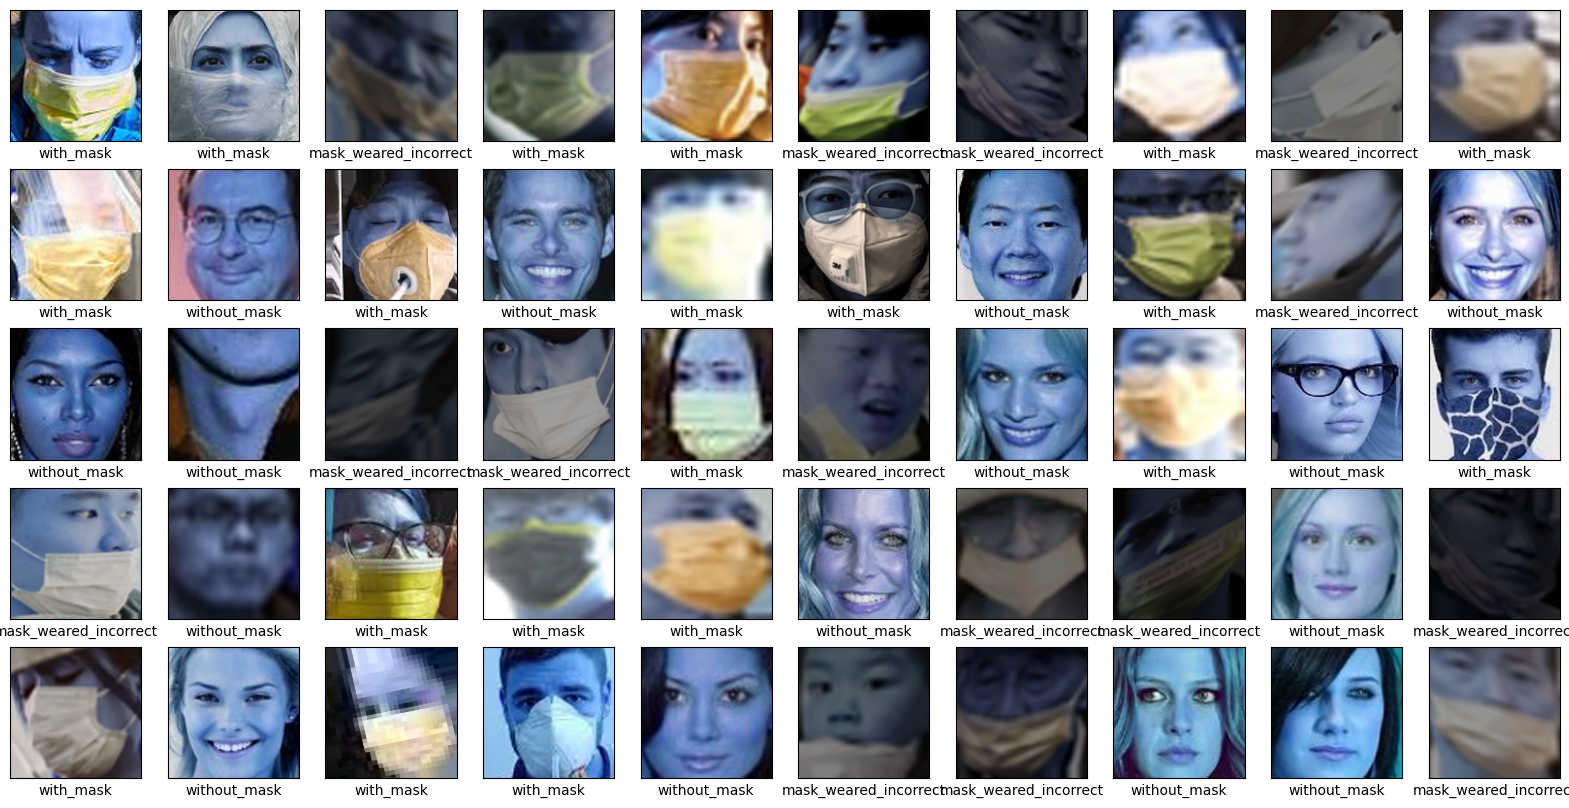

In [4]:
random.shuffle(TRAIN_DATA)

plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(TRAIN_DATA[i][0])
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49:
        break
plt.show()

['mask_weared_incorrect', 'without_mask', 'with_mask']


100%|████████████████████████████████████████████████████████████████████████████| 2994/2994 [00:01<00:00, 2442.09it/s]


8982


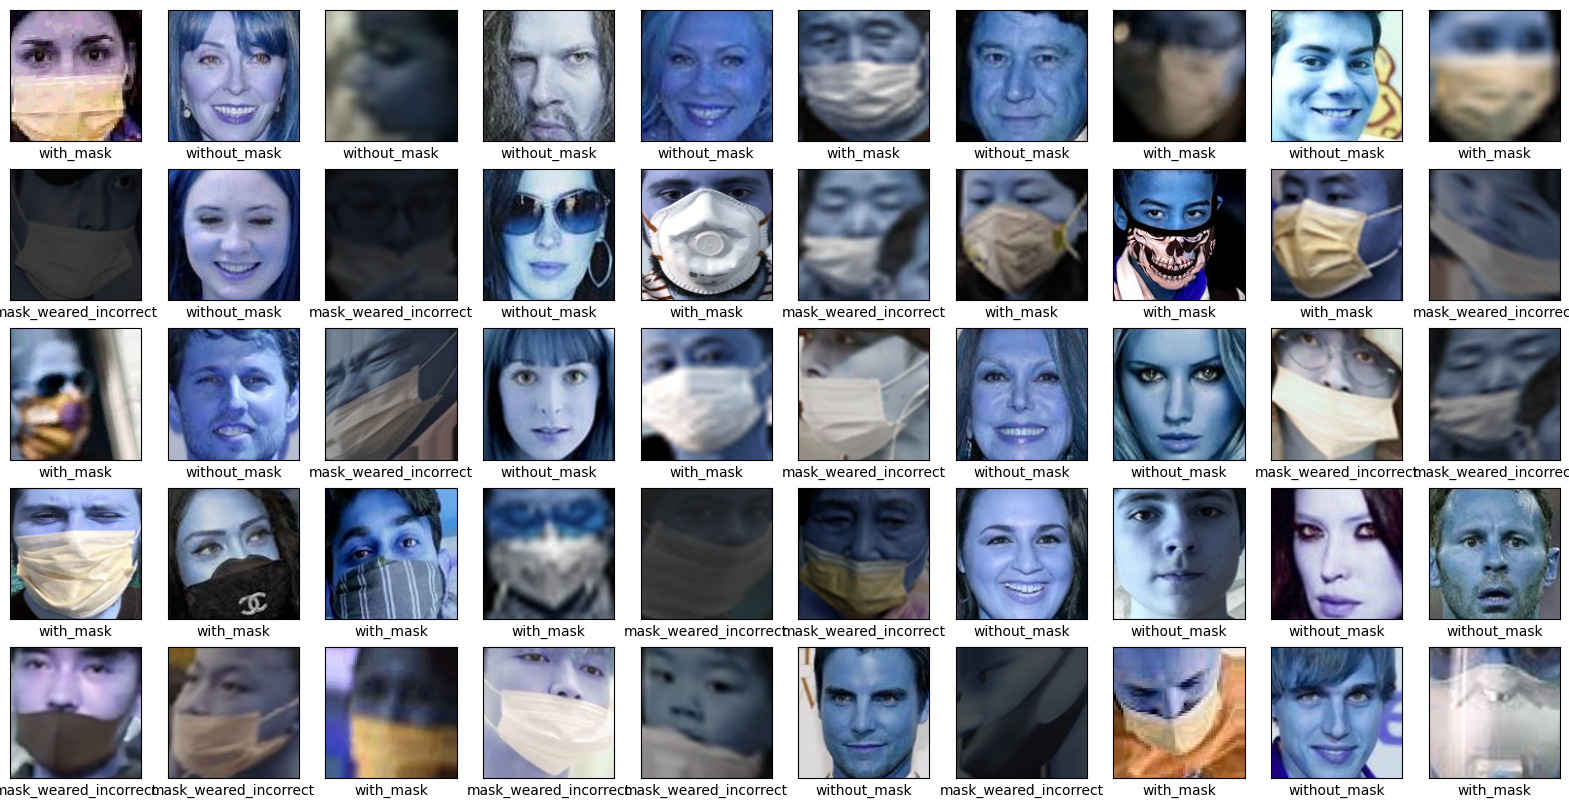

In [52]:
resize = 224   #input image size
epochs = 20
batch_size = 32
learning_rate = 1e-4
seed = 107

#dir_mask = 'drive/MyDrive/content/mask_dataset/Dataset/with_mask'
#dir_inc_mask = 'drive/MyDrive/content/mask_dataset/Dataset/mask_weared_incorrect'
#dir_nomask = 'drive/MyDrive/content/mask_dataset/Dataset/without_mask'
#TRAIN_DIR = 'drive/MyDrive/content/mask_dataset/Dataset'

dir_mask = 'C:/Users/aliah/Desktop/Git Uploads/CVPR/FINAL/mask_dataset/with_mask'
dir_inc_mask = 'C:/Users/aliah/Desktop/Git Uploads/CVPR/FINAL/mask_dataset/mask_weared_incorrect'
dir_nomask = 'C:/Users/aliah/Desktop/Git Uploads/CVPR/FINAL/mask_dataset/without_mask'
TRAIN_DIR = 'C:/Users/aliah/Desktop/Git Uploads/CVPR/FINAL/mask_dataset'

assert os.path.exists(dir_mask), 'Could not find' + dir_mask
assert os.path.exists(dir_inc_mask), 'Could not find' + dir_inc_mask
assert os.path.exists(dir_nomask), 'Could not find' + dir_nomask

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 100.00it/s]


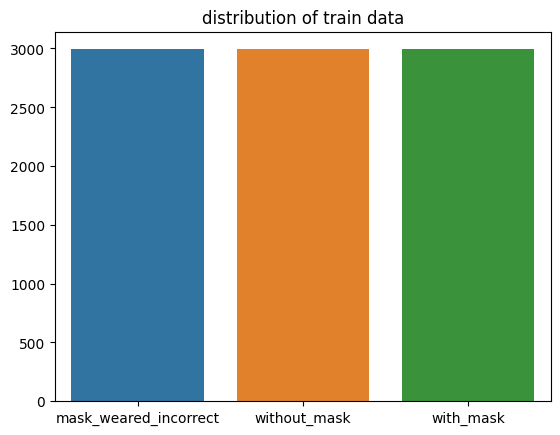

8982


In [42]:
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.png'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")
plt.show()
print(train_exm)

# Joining code starts here
#CATEGORIES = ["with_mask", "mask_weared_incorrect", "without_mask"]
#data = []
#labels = []

#for c in categories:
  #  path = os.path.join(TRAIN_DIR, c)
   # for img in tqdm(os.listdir(path)):
     #   img_path = os.path.join(path, img)
       # image = load_img(img_path, target_size=(244, 244))
       # image = img_to_array(image)
       # image = preprocess_input(image)
        
      #  data.append(image)
      #  labels.append(c)

In [43]:
path_mask = [os.path.abspath(fp) for fp in gb.glob(os.path.join(dir_mask, '*.png'))]
path_inc_mask = [os.path.abspath(fp) for fp in gb.glob(os.path.join(dir_inc_mask, '*.png'))]
path_nomask = [os.path.abspath(fp) for fp in gb.glob(os.path.join(dir_nomask, '*.png'))]

In [44]:
num_mask = len(path_mask)
num_inc_mask = len(path_inc_mask)
num_nomask = len(path_nomask)

In [45]:
label_mask = [0] * num_mask
label_inc_mask = [1] * num_inc_mask
label_nomask = [2] * num_nomask

print('#mask:    ', num_mask)
print('#inc_mask:', num_inc_mask)
print('#nomask:  ', num_nomask)

#mask:     2994
#inc_mask: 2994
#nomask:   2994


In [46]:
RATIO_TEST = 0.2

num_mask_test = int(num_mask * RATIO_TEST)
num_inc_mask_test = int(num_inc_mask * RATIO_TEST)
num_nomask_test = int(num_nomask * RATIO_TEST)

In [47]:
#train
path_train = path_mask[num_mask_test:] + path_inc_mask[num_inc_mask_test:] + path_nomask[num_nomask_test:]
label_train = label_mask[num_mask_test:] + label_inc_mask[num_inc_mask_test:] + label_nomask[num_nomask_test:]

#validation
path_vali = path_mask[:num_mask_test] + path_inc_mask[:num_inc_mask_test] + path_nomask[:num_nomask_test]
label_vali = label_mask[:num_mask_test] + label_inc_mask[:num_inc_mask_test] + label_nomask[:num_nomask_test]
num_train = len(path_train)
num_vali = len(path_vali)

print(num_train)
print(num_vali)

7188
1794


In [48]:
def preproc(path, label):
    image_byte = tf.io.read_file(path)
    image = tf.io.decode_image(image_byte)
    image_resize = tf.image.resize_with_pad(image, 224, 224)  
    image_norm = preprocess_input(image_resize) 

    label_onehot = tf.one_hot(label, 2)

    return image_norm, label_onehot


dataset_train = tf.data.Dataset.from_tensor_slices((path_train,label_train))
dataset_train = dataset_train.shuffle(num_train).repeat()
dataset_train =  dataset_train.map(preproc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

dataset_vali = tf.data.Dataset.from_tensor_slices((path_vali, label_vali))
dataset_vali = dataset_vali.shuffle(num_vali).repeat()
dataset_vali = dataset_vali.map(preproc, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_vali = dataset_vali.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [49]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

In [38]:
# construct the head of the model that will be placed on top of the
# the base model (a simple CNN as the Head model)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [50]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
#freeze MobileNet V2 layers, so only the headmodel can train on the data, 
#while the base model can use the previously trained weights
for layer in baseModel.layers:
    layer.trainable = False

# compile our model

opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_rate / epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])




history= model.fit(dataset_train,
          steps_per_epoch = num_train//batch_size,
          epochs = epochs,         
          validation_data = dataset_vali,
          validation_steps = num_vali//batch_size,
          verbose = 1)
scores = model.evaluate(dataset_train, steps=num_train//batch_size, verbose=1)
print(scores)

scores = model.evaluate(dataset_vali, steps=num_train//batch_size, verbose=1)
print(scores)
model.save("my_mask_detector.model", save_format="h5")

Epoch 1/20
224/224 [==============================] - 75s 329ms/step - loss: 2.7983 - accuracy: 0.6815 - val_loss: 0.3071 - val_accuracy: 0.7656
Epoch 2/20
224/224 [==============================] - 69s 306ms/step - loss: 3.5917 - accuracy: 0.6804 - val_loss: 0.3071 - val_accuracy: 0.8030
Epoch 3/20
224/224 [==============================] - 67s 299ms/step - loss: 4.1266 - accuracy: 0.6804 - val_loss: 0.3648 - val_accuracy: 0.7891
Epoch 4/20
156/224 [===================>..........] - ETA: 15s - loss: 4.6131 - accuracy: 0.6903

KeyboardInterrupt: 